## Version 1 - No Utilities

In [ ]:
import random

class Agent:

    def __init__(self, name, id, goal):
        self.name = name
        self.id = id
        self.goal = goal
        self.actions = [
            "apply force",
            "do nothing"
        ]
        self.history = []
        self.points = 0
        self.game_ended = "No"

    # ignore ##########################################
    def calculate_utility(self, action, other_agent):
        # Calculate the utility of the action
        if action == "apply force":
            if other_agent.goal == "survive":
                
                # If the other agent complies, the agent gets a high utility
                if random.random() < 0.5:
                    self.points += 1
                    return 1.0
                else:
                    # If the other agent resists, the agent gets a low utility
                    self.points +=0
                    return 0.0
            else:
                # If the other agent has a different goal, the agent gets a negative utility
                self.points += -1
                return -1.0
        else:
            # If the agent does nothing, the utility is zero
            self.points += 0
            return 0.0
    ############################################### 
    
    def act(self, other_agent):
        # Choose the action with the highest utility
        action = self.actions[self.calculate_utility(self.actions[0], other_agent) > self.calculate_utility(self.actions[1], other_agent)]
        
        # no one has played yet, so 
        if len(self.history) == 0 and len(other_agent.history) == 0:
            print(f"\t{self.name} starts the game.")
            # [DEBUG] the agent starts in node 5
            self.game_node = 5
            
            # choose randomly between "apply force" and "do nothing"
            action = random.choice(self.actions)
            
        # if the other agent has played, then look at the subgame path
        else:
            # TODO: we should weight these conditions with the respective utilities
            ## capitulation could be an alternative goal towards war
            if (self.goal == "WAR") and (other_agent.history[-1] == "apply force") :
                action = "apply force"
            
            if (self.goal == "WAR") and (other_agent.history[-1] == "do nothing") :
                action = "apply force"
                
            if (self.goal == "NEGO") and (other_agent.history[-1] == "apply force") :
                action = "do nothing"
        
            if (self.goal == "NEGO") and (other_agent.history[-1] == "do nothing") :
                action = "do nothing"
                
            if (self.goal == "CAPITULATION" ) and (other_agent.history[-1] == "apply force") :
                action = "do nothing"
                
            if (self.goal == "CAPITULATION") and (other_agent.history[-1] == "do nothing") :
                action = "do nothing"
        

        # add action to the records
        self.history.append(action)
        
        # Perform the action
        print(f"\t{self.name} used {action} to {other_agent.name}")
        
        
    def update_state(self, other_agent):
        print("\tUpdating the state of the world...")
        if (self.history[-1] == "apply force") and (self.game_node == 5):
            other_agent.game_node = 10 # move to node 10
        if (self.history[-1] == "do nothing") and (self.game_node == 5):
            other_agent.game_node = 9 # move to node 9
        
        if (self.history[-1] == "apply force") and (self.game_node == 10):
            other_agent.game_ended = "   ->WAR to " + self.name
            
        if (self.history[-1] == "do nothing") and (self.game_node == 10):
            other_agent.game_ended = "   ->CAP to " + self.name
        
        if (self.game_node == 9) and (self.history[-1] == "apply force"):
            # switch branch and go to node 8
            other_agent.game_node = 8
        if (self.game_node == 9) and (self.history[-1] == "do nothing"):
            # switch branch and go to node 8
            self.game_ended = "   ->Negotiation between " + self.name + " and " + other_agent.name
        
        if (self.history[-1] == "apply force") and (self.game_node == 8):
            self.game_ended = "WAR to " + other_agent.name
        if (self.history[-1] == "do nothing") and (self.game_node == 8):
            self.game_ended = "   ->CAP to " + self.name
        
        if self.goal in self.game_ended:
        # Check if the goal has been achieved
            self.goal_reached = True
            print(f"\t{self.name} achieved their goal.")
            return
            
        if other_agent.goal in self.game_ended:
            other_agent.goal_reached = True
            print(f"\t{other_agent.name} achieved their goal.")
            return

# Create two agents
agent1 = Agent("Agent 1", 1, "NEGO")
agent2 = Agent("Agent 2", 2, "NEGO")

# Let the agents interact
i = 0
while i < 10:
    
    print(f"GAME ITERATION {i}")
    
    print(f"AGENT 1    GOAL {agent1.goal}")
    agent1.act(agent2)
    agent1.update_state(agent2)
    print(f"        DEBUG: " , ["node: " + str(agent1.game_node), agent1.history, agent1.game_ended])
    
    
    if agent1.goal_reached == True:
        print("\n")
        print(f"{agent1.name} won!")
        break
    
    if agent2.goal_reached == True:
        print("\n")
        print(f"{agent2.name} won!")
        break
    
    if agent1.game_ended != "No":
        print("\n")
        print(f"{agent1.name} and {agent2.name} lost!")
        break
    
    
    print("\n")
    
    print(f"AGENT 2    GOAL {agent1.goal}") 
    agent2.act(agent1)
    agent2.update_state(agent1)
    print(f"        DEBUG: ", [ "node: " + str(agent2.game_node), agent2.history, agent2.game_ended])
    print("---------------------")
    
    if agent1.goal_reached == True:
        print("\n")
        print(f"{agent1.name} won!")
        break
    
    if agent2.goal_reached == True:
        print("\n")
        print(f"{agent2.name} won!")
        break
    
    if agent2.game_ended != "No":
        print("\n")
        print(f"{agent2.name} lost!")
        break

    i += 1
    
    

In [ ]:
# Print the history of the agents
print(f"{agent1.name} history: {agent1.history}")


## Version 2 - Backward Induction

In [1]:
!cd /Users/pin083/Documents/GitHub/International_Interaction_Game/agent_based_model_approach/

In [2]:
import pyAgrum as gum
from pylab import *
import pyAgrum.lib.notebook as gnb

from node import Node
from agent import Agent

In [3]:
# build tree
def build_game_tree(utilities_agent1, utilities_agent2):

    game_tree_dict = {}
    node_CAP1 = Node("CAP1", -1, [], [], -1, False, utilities_agent1["CAP1"], utilities_agent2["CAP1"])
    game_tree_dict["CAP1"] = node_CAP1
    
    node_WAR2 = Node("WAR2", -1, [], [], -1, False, utilities_agent1["WAR2"], utilities_agent2["WAR2"])
    game_tree_dict["WAR2"] = node_WAR2

    node_NEG  = Node("NEG",  -1, [], [], -1, False, utilities_agent1["NEG"], utilities_agent2["NEG"])
    game_tree_dict["NEG"] = node_NEG
    
    node_CAP2 = Node("CAP2", -1, [], [], -1, False, utilities_agent1["CAP2"], utilities_agent2["CAP2"])
    game_tree_dict["CAP2"] = node_CAP2
    
    node_WAR1 = Node("WAR1", -1, [], [], -1, False, utilities_agent1["WAR1"], utilities_agent2["WAR1"])
    game_tree_dict["WAR1"] = node_WAR1

    node_ACQ1 = Node("ACQ1", -1, [], [], -1, False, utilities_agent1["ACQ1"], utilities_agent2["ACQ1"])
    game_tree_dict["ACQ1"] = node_ACQ1
    
    node_ACQ2 = Node("ACQ2", -1, [], [], -1, False, utilities_agent1["ACQ2"], utilities_agent2["ACQ2"])
    game_tree_dict["ACQ2"] = node_ACQ2
    
    node_SQ   = Node("SQ",   -1, [], [], -1, False, utilities_agent1["SQ"], utilities_agent2["SQ"])
    game_tree_dict["SQ"] = node_SQ

    node_12 = Node("12", -1, [node_CAP1, node_WAR2], [], 1, False, -1, -1)
    game_tree_dict["12"] = node_12
    
    node_11 = Node("11", -1, [node_CAP2, node_WAR1], [], 2, False, -1, -1)
    game_tree_dict["11"] = node_11
    
    node_10 = Node("10", -1, [node_CAP2, node_WAR1], [], 2, False, -1, -1)
    game_tree_dict["10"] = node_10
    
    node_9 =  Node("9", -1,  [node_NEG, node_12], [], 2, False, -1, -1)
    game_tree_dict["9"] = node_9
    
    node_8 =  Node("8", -1,  [node_CAP1, node_WAR2], [], 1, False, -1, -1)
    game_tree_dict["8"] = node_8
    
    node_7 =  Node("7", -1,  [node_NEG, node_11], [], 1, False, -1, -1)
    game_tree_dict["7"] = node_7
    
    node_6 =  Node("6", -1,  [node_7, node_8], [], 2, False, -1, -1)
    game_tree_dict["6"] = node_6
    
    node_5 =  Node("5", -1,  [node_9, node_10], [], 1, False, -1, -1)
    game_tree_dict["5"] = node_5
    
    node_4 =  Node("4", -1,  [node_ACQ1, node_6], [], 1, False, -1, -1)
    game_tree_dict["4"] = node_4
    
    node_3 =  Node("3", -1,  [node_ACQ2, node_5], [], 2, False, -1, -1)
    game_tree_dict["3"] = node_3
    
    node_2 =  Node("2", -1,  [node_SQ, node_4], [], 2, False, -1, -1)
    game_tree_dict["2"] = node_2
    
    node_1 = Node("1", -1,  [node_2, node_3], [], 1, False, -1, -1)
    game_tree_dict["1"] = node_1
    
    return  node_1, game_tree_dict

    

In [4]:
# visualise the tree
def get_all_nodes(node, level, lst):
    lst.append(node.get_name())
    for child in node.get_children():
        get_all_nodes(child, level + 1, lst)

In [5]:
def visualize_tree_graphviz(root_node, game_tree_dict, perspective):
    bn=gum.BayesNet(f'Game Tree - Agent {perspective}')
    
    node_lst =[]
    get_all_nodes(root_node, 0, node_lst)
    
    # remove duplicates from node_lst
    node_lst = list(set(node_lst))
    
    for node_name in node_lst:
        
        util = np.round(game_tree_dict[node_name].get_utility()[perspective - 1], 2)
        if perspective > 0:
            bn.add(f"{node_name}_{util}" , 2)  
        else:
            bn.add(node_name , 2) 
    
    traverse_tree(root_node, 0, bn,  game_tree_dict, perspective)
    return bn
    
def traverse_tree(node, level, bn, game_tree_dict, perspective ):
    
    util = np.round(game_tree_dict[node.get_name()].get_utility()[perspective - 1], 2)
    
    node_name = f"{node.get_name()}_{util}" if perspective > 0 else node.get_name()

    node_id = bn.idFromName(node_name)
    for child in node.get_children():
        
        util = np.round(game_tree_dict[child.get_name()].get_utility()[perspective - 1], 2)
        child_name = f"{child.get_name()}_{util}" if perspective > 0 else child.get_name()

        child_id = bn.idFromName(child_name)

        bn.addArc(node_id,child_id)
        traverse_tree(child, level + 1, bn,  game_tree_dict, perspective)
        
def nodevalue(n):
    if n in {"1", "5", "12", "8", "7", "4"}:
        return 0
    
    elif n in {"2", "3", "6", "9", "10", "11"}:
        return 1
    
    else:
        return 8

In [6]:
import pandas as pd
DATASET_PATH = "/Users/pin083/Documents/GitHub/International_Interaction_Game/dataset/utilities.csv"
utilities = pd.read_csv(DATASET_PATH, sep="\t")

def create_agent_pair( indx : int, utilities ):
    
    util_agent1 = {}
    agent1_name = utilities.loc[indx, "Agent1"]
    util_agent1["SQ"] = utilities.loc[indx, "wrTu1sq"]
    util_agent1["ACQ1"] = utilities.loc[indx, "wrTu1ac1"]
    util_agent1["ACQ2"] = utilities.loc[indx, "wrTu1ac2"]
    util_agent1["NEG"] = utilities.loc[indx, "wrTu1neg"]
    util_agent1["CAP1"] = utilities.loc[indx, "wrTu1cp1"]
    util_agent1["CAP2"] = utilities.loc[indx, "wrTu1cp2"]
    util_agent1["WAR1"] = utilities.loc[indx, "wrTu1wr1"]
    util_agent1["WAR2"] = utilities.loc[indx, "wrTu1wr2"]

    agent2_name = utilities.loc[indx, "Agent2"]
    util_agent2 = {}
    util_agent2["SQ"] = utilities.loc[indx, "wrTu2sq"]
    util_agent2["ACQ1"] = utilities.loc[indx, "wrTu2ac2"]
    util_agent2["ACQ2"] = utilities.loc[indx, "wrTu2ac1"]
    util_agent2["NEG"] = utilities.loc[indx, "wrTu2neg"]
    util_agent2["CAP1"] = utilities.loc[indx, "wrTu2cp2"]
    util_agent2["CAP2"] = utilities.loc[indx, "wrTu2cp1"]
    util_agent2["WAR1"] = utilities.loc[indx, "wrTu2wr2"]
    util_agent2["WAR2"] = utilities.loc[indx, "wrTu2wr1"]
    
    game_tree, game_tree_dict = build_game_tree(util_agent1, util_agent2)
    
    agent1 = Agent(agent1_name, 1, util_agent1)
    agent2 = Agent(agent2_name, 2, util_agent2)
    
    groundtruth = utilities.loc[indx, "groundtruth"]
    predicted = utilities.loc[indx, "predicted"]

    return agent1, agent2, groundtruth, predicted, game_tree, game_tree_dict


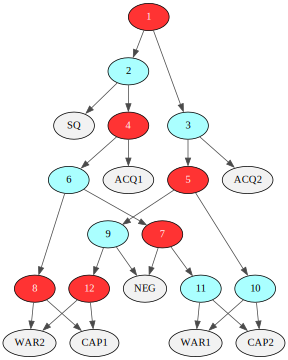

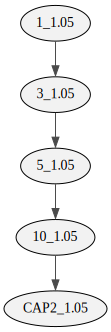

GAME USA VS ESP...

GAME ITERATION 0

AGENT USA TURN
	USA used apply force
UPDATE STATE
1
apply force
        DEBUG: node: ('1', ['apply force'], 'NO')]


AGENT ESP TURN
	ESP used apply force
UPDATE STATE
3
apply force
        DEBUG: node: ('3', ['apply force'], 'NO')]
---------------------------------------------------------------------
GAME ITERATION 1

AGENT USA TURN
	USA used apply force
UPDATE STATE
5
apply force
        DEBUG: node: ('5', ['apply force', 'apply force'], 'NO')]


AGENT ESP TURN
	ESP used do nothing
UPDATE STATE
10
do nothing
        DEBUG: node: ('10', ['apply force', 'do nothing'], 'NO')]
---------------------------------------------------------------------
GAME ENDED USA VS ESP: CAP2






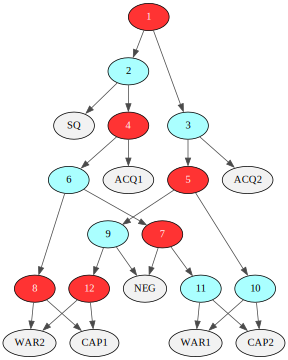

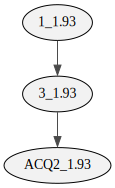

GAME RUS VS TUR...

GAME ITERATION 0

AGENT RUS TURN
	RUS used apply force
UPDATE STATE
1
apply force
        DEBUG: node: ('1', ['apply force'], 'NO')]


AGENT TUR TURN
	TUR used do nothing
UPDATE STATE
3
do nothing
        DEBUG: node: ('3', ['do nothing'], 'NO')]
---------------------------------------------------------------------
GAME ENDED RUS VS TUR: ACQ2






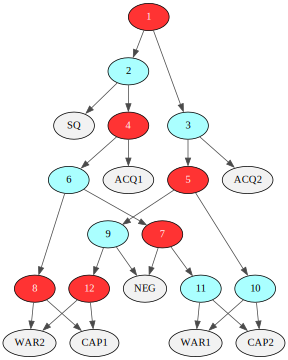

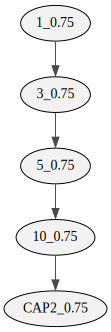

GAME TUR VS RUS...

GAME ITERATION 0

AGENT TUR TURN
	TUR used apply force
UPDATE STATE
1
apply force
        DEBUG: node: ('1', ['apply force'], 'NO')]


AGENT RUS TURN
	RUS used apply force
UPDATE STATE
3
apply force
        DEBUG: node: ('3', ['apply force'], 'NO')]
---------------------------------------------------------------------
GAME ITERATION 1

AGENT TUR TURN
	TUR used apply force
UPDATE STATE
5
apply force
        DEBUG: node: ('5', ['apply force', 'apply force'], 'NO')]


AGENT RUS TURN
	RUS used do nothing
UPDATE STATE
10
do nothing
        DEBUG: node: ('10', ['apply force', 'do nothing'], 'NO')]
---------------------------------------------------------------------
GAME ENDED TUR VS RUS: CAP2






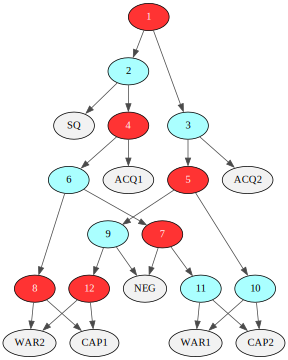

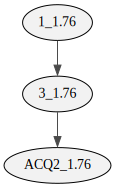

GAME FRA VS ESP...

GAME ITERATION 0

AGENT FRA TURN
	FRA used apply force
UPDATE STATE
1
apply force
        DEBUG: node: ('1', ['apply force'], 'NO')]


AGENT ESP TURN
	ESP used do nothing
UPDATE STATE
3
do nothing
        DEBUG: node: ('3', ['do nothing'], 'NO')]
---------------------------------------------------------------------
GAME ENDED FRA VS ESP: ACQ2






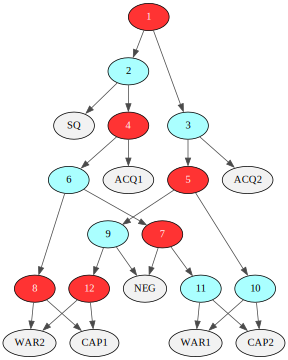

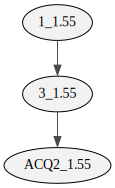

GAME xxx VS ITA...

GAME ITERATION 0

AGENT xxx TURN
	xxx used apply force
UPDATE STATE
1
apply force
        DEBUG: node: ('1', ['apply force'], 'NO')]


AGENT ITA TURN
	ITA used do nothing
UPDATE STATE
3
do nothing
        DEBUG: node: ('3', ['do nothing'], 'NO')]
---------------------------------------------------------------------
GAME ENDED xxx VS ITA: ACQ2






In [13]:
outcomes = []
groundtruths = []
preds = []
for game in {0,1, 2, 3, 4}: #range(0, len(utilities)):
    agent1, agent2, groundtruth, predicted, game_tree, game_tree_dict = create_agent_pair(game, utilities)
    agent1, agent2, groundtruth, predicted, game_tree_2, game_tree_dict_2 = create_agent_pair(game, utilities)
    
    # initial game tree for
    bn1 = visualize_tree_graphviz(game_tree, game_tree_dict, 0)
    gnb.showBN(bn1, nodeColor={n:nodevalue(n) for n in bn1.names()})
    
    bn2 = visualize_tree_graphviz(game_tree_2, game_tree_dict_2, 0)
    
    agent1.current_node = 1         # keeping track of where the agent is in the tree
    agent1.start_node = 1
    # Let the agents interact
    
    # apply backward induction
    bn_agent1, game_tree_dict = agent1.backward_induction(agent2, bn1, game_tree_dict)
    
    bn = visualize_tree_graphviz(game_tree_dict["1"], game_tree_dict, 1)
    gnb.showBN(bn, nodeColor={n:nodevalue(n) for n in bn.names()})
    
    print(f"GAME {agent1.name} VS {agent2.name}...\n" )
    for i in range(100):
        
        print(f"GAME ITERATION {i}\n")
        
        print(f"AGENT {str(agent1.name)} TURN")
        agent1.apply_action(agent2, game_tree_dict)
        agent1.update_state(agent2)
        print(f"        DEBUG: node: {str(agent1.current_node), agent1.history, agent1.game_ended}]")
        
        print("\n")
        
        print(f"AGENT {str(agent2.name)} TURN")
        agent2.apply_action(agent1, game_tree_dict)
        agent2.update_state(agent1)
        print(f"        DEBUG: node: {str(agent2.current_node), agent2.history, agent2.game_ended}]")
        

        print("---------------------------------------------------------------------")
        
        if agent1.game_ended != "NO":
            print(f"GAME ENDED {agent1.name} VS {agent2.name}: {agent1.game_ended}")
            outcomes.append(agent1.game_ended.upper())
            groundtruths.append(groundtruth.upper())
            preds.append(predicted.upper())
            break
        
        if agent2.game_ended != "NO":
            print(f"GAME ENDED {agent1.name} VS {agent2.name}: {agent2.game_ended}")
            outcomes.append(agent1.game_ended.upper())
            groundtruths.append(groundtruth.upper())
            preds.append(predicted.upper())
            break
        
    print("\n")
    print("\n")
        


In [ ]:
bn2

[[  0   0   0   0   0   0   0   0]
 [  0   0 105   0   0  41   0   0]
 [  0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0  11   0   0   9   0   0]
 [  0   0 129   0   0  45   0   0]
 [  0   0  94   0   0  35   0   0]
 [  0   0   0   0   0   0   0   0]]
0.09036144578313253
0.05823293172690763
0.014056224899598393


<Axes: >

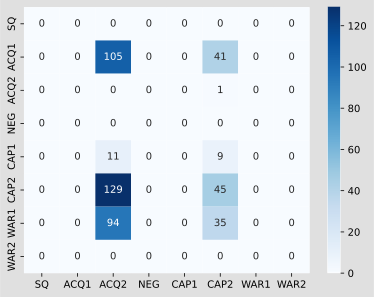

In [15]:
# compute confusion matrix between groundtruths and outcomes
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

confusion_matrix = confusion_matrix(groundtruths, outcomes, labels=["SQ", "ACQ1", "ACQ2", "NEG", "CAP1", "CAP2", "WAR1", "WAR2"])
print(confusion_matrix)

# compute accuracy
accuracy = accuracy_score(groundtruths, outcomes)
print(accuracy)

accuracy_other = accuracy_score(groundtruths, preds)
print(accuracy_other)

accuracy_other = accuracy_score(outcomes, preds)
print(accuracy_other)


# plot confusion matrix
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap="Blues", fmt="d", xticklabels=["SQ", "ACQ1", "ACQ2", "NEG", "CAP1", "CAP2", "WAR1", "WAR2"], yticklabels=["SQ", "ACQ1", "ACQ2", "NEG", "CAP1", "CAP2", "WAR1", "WAR2"])

